In [ ]:
import os
import random
import shutil
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [113]:
!dir="/mnt/e/UBB_IE_2020-2023/S6.BE/v3_backup_$(date +%Y-%m-%d_%H-%M-%S)/"; mkdir "$dir" && cp -r /mnt/e/UBB_IE_2020-2023/S6.BE/v3/{tracker.h5,data,aug_data} "$dir"

In [6]:
import re
import os


def remove_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for file in filter(lambda x: re.match(pattern, x), files):
            os.remove(os.path.join(root, file))


remove_files('data', '.*\.(jpg|json)')
remove_files('aug_data', '.*\.(jpg|json)')

In [72]:
from braceexpand import braceexpand

# https://www.google.com/search?q=python+make+dirs+like+bash+bracket+expansion -> https://stackoverflow.com/questions/22996645/brace-expansion-in-python-glob
def make_data_dirs_tree(brace_patter_path):
    for file in braceexpand(brace_patter_path):
        os.makedirs(file)

In [71]:
#!mkdir -p data/{,train,test,val}/{images,labels}
dirs_glob_pattern = os.path.join('data', '{,train,test,val}', '{images,labels}')
make_data_dirs_tree(dirs_glob_pattern)

In [15]:
import os
import time
import uuid
import cv2

In [ ]:
# Fails with webcam
import cv2
camera = cv2.VideoCapture(0)
print(camera.isOpened()) # False
print(camera.read()) # (False, None)
camera.release()
cv2.destroyAllWindows()

In [3]:
import cv2

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

90 lumina aprina aproape (si in colturi)  
90 lumina stinsa aproape (si in colturi)  
90 lumina aprinsa departe (si in colturi)  
90 lumina stinsa departe (si in colturi)  

In [ ]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{(imgnum + 1):02d}_{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [1]:
!find . -iwholename "**/cv2/qt/plugins" -exec rm -r {} \;
!labelme --autosave --output data/labels

find: ‘./handrecognitionvenv/lib/python3.11/site-packages/cv2/qt/plugins’: No such file or directory
[INFO   ] __init__:get_config:70 - Loading config file from: /home/kamui/.labelmerc


In [39]:
import os
import shutil
from datetime import datetime

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

source_dir = 'data'
destination_dir = os.path.join('..', f'v3_data_backup_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}')
copytree(source_dir, destination_dir)
# !cp -r data ../v3_data_backup_$(date +%Y-%m-%d_%H-%M-%S)

In [16]:
import tensorflow as tf
import json
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-01 13:29:02.450276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 13:29:02.532799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 13:29:02.533057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# run tensorflow on gpu -> https://www.tensorflow.org/guide/gpu#logging_device_placement
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [55]:
import os
images = tf.data.Dataset.list_files(os.path.join('data', 'images', '*.jpg'), shuffle=False)

2023-11-25 10:42:22.287583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 10:42:22.456857: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [12]:
images.as_numpy_iterator().next()

b'data/images/0132fc4e-896c-11ee-aed7-df8acdbd3581.jpg'

In [52]:
def load_image(path): 
    byte_img = tf.io.read_file(path)
    loaded_image = tf.io.decode_jpeg(byte_img)
    return loaded_image

In [54]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [ ]:
images.as_numpy_iterator().next()

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [23]:
plot_images = image_generator.next()

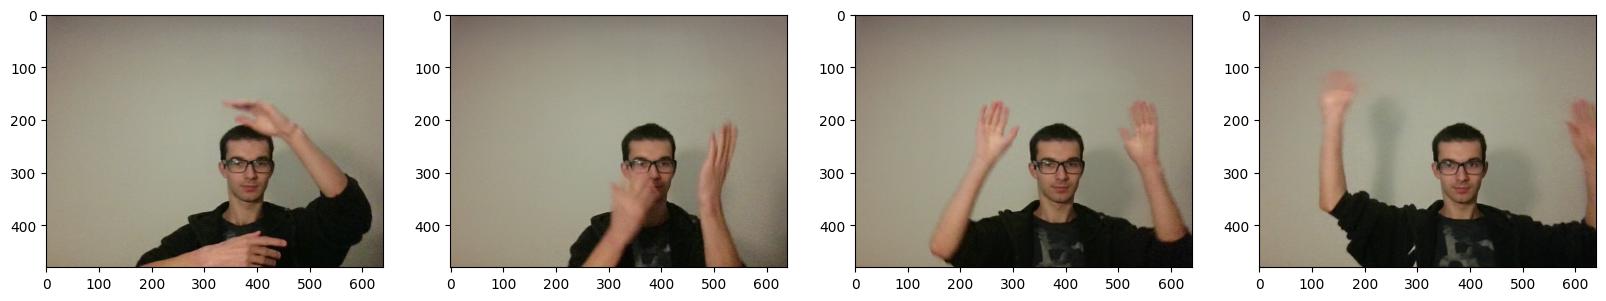

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Split Images

In [30]:
len(os.listdir(os.path.join('data', 'images')))

0

In [10]:
## linux move n random files -> https://stackoverflow.com/questions/14033129/how-to-move-a-given-number-of-random-files-on-unix-linux-os
# !shuf -n 63 -e data/images/* | xargs -i mv {} data/train/images
# !shuf -n 14 -e data/images/* | xargs -i mv {} data/test/images
# !shuf -n 13 -e data/images/* | xargs -i mv {} data/val/images
import os
import shutil
import random


def shuffle_and_move(count: int, data_dir: str):
    source_directory = os.path.join('data', 'images')
    destination_directory = os.path.join('data', data_dir, 'images')
    files = os.listdir(source_directory)
    random.shuffle(files)
    files = files[:count]
    for file in files:
        old_path = os.path.join(source_directory, file)
        new_path = os.path.join(destination_directory, file)
        shutil.move(old_path, new_path)


total = len(os.listdir(os.path.join('data', 'images')))
train_count = int(total * 0.75)
test_and_val = total - train_count
test_count = int(test_and_val * 0.5)
val_count = test_and_val - test_count

shuffle_and_move(train_count, 'train')
shuffle_and_move(test_count, 'test')
shuffle_and_move(val_count, 'val')

for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [31]:
import cv2
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [33]:
img_name = os.listdir(os.path.join('data', 'train', 'images'))[0]
print(img_name)
img = cv2.imread(os.path.join('data', 'train', 'images', img_name))


03a1c04c-8bb4-11ee-b844-546ceb7ca989.jpg


In [35]:
with open(os.path.join('data', 'train', 'labels', img_name.replace('.jpg', '.json')), 'r') as f:
    label = json.load(f)

In [37]:
label['shapes'][0]['points']

[[552.2900763358779, 166.9083969465649],
 [615.3944020356233, 243.11704834605598]]

In [38]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [39]:
coords

[552.2900763358779, 166.9083969465649, 615.3944020356233, 243.11704834605598]

In [41]:
coords = list(np.divide(coords, [640,480,640,480]))

In [42]:
coords

[0.0013483644441793893,
 0.0007244288061916879,
 0.0015024277393447835,
 0.0010551955223353125]

In [45]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])

In [46]:
augmented['bboxes'][0][2:]

IndexError: list index out of range

In [47]:
augmented['bboxes']

[]

In [48]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

IndexError: list index out of range

In [74]:
# !mkdir -p aug_data/{train,test,val}/{images,labels}
dirs_glob_pattern = os.path.join('aug_data', '{train,test,val}', '{images,labels}')
make_data_dirs_tree(dirs_glob_pattern)

In [49]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),
                            augmented['image'])

                annotation = {'image': image}

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.2517703201970444, 0.36094006568144493, 0.0, 0.0018494675822260831, 'hand'].
x_max is less than or equal to x_min for bbox [0.14401169950738923, 0.3229679802955665, 0.0023860837438424596, 0.5795361247947455, 'hand'].
x_max is less than or equal to x_min for bbox [0.14632081280788184, 0.32707307060755336, 0.0, 0.5875394389566625, 'hand'].
x_max is less than or equal to x_min for bbox [0.15016933497536952, 0.31886288998357964, 0.0, 0.5827968726675625, 'hand'].
y_max is less than or equal to y_min for bbox [0.06704125615763556, 0.16389573070607558, 0.1347752463054188, 0.0007183908045977474, 'hand'].
x_max is less than or equal to x_min for bbox [0.1032173645320198, 0.030480295566502506, 0.0008466748768473864, 0.2039203612479475, 'hand'].
x_max is less than or equal to x_min for bbox [0.10860529556650256, 0.027401477832512358, 0.0016163793103449286, 0.2039203612479475, 'hand'].
x_max is less than or equal to x_min for bbox [0.1055264778325124

In [23]:
def load_image(path): 
    byte_img = tf.io.read_file(path)
    loaded_image = tf.io.decode_jpeg(byte_img)
    return loaded_image

def load_images_into_dataset(dir_name: str):
    loaded_images = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'images', '*.jpg'), shuffle=False)
    loaded_images = loaded_images.map(load_image)
    loaded_images = loaded_images.map(lambda y: tf.image.resize(y, (120, 120)))
    loaded_images = loaded_images.map(lambda y: y / 255)
    return loaded_images

In [24]:
train_images = load_images_into_dataset('train')
test_images = load_images_into_dataset('test')
val_images = load_images_into_dataset('val')

In [25]:
train_images.as_numpy_iterator().next()

array([[[0.6181985 , 0.57898283, 0.54221815],
        [0.6150122 , 0.57579654, 0.53903186],
        [0.61599267, 0.576777  , 0.54001224],
        ...,
        [0.6449142 , 0.6086397 , 0.5601103 ],
        [0.64362746, 0.6122549 , 0.5612745 ],
        [0.64319855, 0.606924  , 0.5583946 ]],

       [[0.6107843 , 0.5715686 , 0.5323529 ],
        [0.60974264, 0.57052696, 0.5313113 ],
        [0.6156863 , 0.5764706 , 0.5372549 ],
        ...,
        [0.6505515 , 0.61917895, 0.56917894],
        [0.6401348 , 0.60876226, 0.5577819 ],
        [0.646875  , 0.6106005 , 0.56697303]],

       [[0.6197304 , 0.5805147 , 0.54129905],
        [0.6191176 , 0.57990193, 0.54068625],
        [0.6192402 , 0.5800245 , 0.5408088 ],
        ...,
        [0.64840686, 0.6170343 , 0.57389706],
        [0.65042895, 0.61905634, 0.5759191 ],
        [0.6458946 , 0.61452204, 0.5713848 ]],

       ...,

       [[0.51029414, 0.4343137 , 0.28186274],
        [0.47205883, 0.39362746, 0.2495098 ],
        [0.50281864, 0

# Prepare Labels

In [26]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [27]:
def load_labels_into_dataset(dir_name: str):
    loaded_labels = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'labels', '*.json'), shuffle=False)
    loaded_labels = loaded_labels.map(lambda y: tf.py_function(load_labels, [y], [tf.int32, tf.float32]))
    return loaded_labels

train_labels = load_labels_into_dataset('train')
test_labels = load_labels_into_dataset('test')
val_labels = load_labels_into_dataset('val')

In [28]:
train_labels.as_numpy_iterator().next()


(array([1], dtype=int32),
 array([0.        , 0.33312976, 0.01491094, 0.50248235], dtype=float32))

# Combine Images and Labels

In [29]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(16140, 16140, 2640, 2640, 2700, 2700)

In [34]:
def zip_dataset(images_, labels):
    return tf.data.Dataset.zip((images_, labels)).shuffle(len(labels) + 1).batch(8).prefetch(4)

train = zip_dataset(train_images, train_labels)
test = zip_dataset(test_images, test_labels)
val = zip_dataset(val_images, val_labels)

In [35]:
len(train), len(test), len(val)

(2018, 330, 338)

In [36]:
train.as_numpy_iterator().next()[1]

2023-12-01 13:32:36.400987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 10861 of 32280
2023-12-01 13:32:40.855054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0]], dtype=int32),
 array([[0.67975914, 0.41038862, 0.81331146, 0.60852766],
        [0.18609743, 0.50124794, 0.4488232 , 0.79681444],
        [0.81078273, 0.63168037, 1.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.13304871, 0.6274658 , 0.25893816, 0.80918443],
        [0.47425288, 0.38782704, 0.7304105 , 0.7468856 ],
        [0.2870844 , 0.        , 0.5267694 , 0.16881356],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32))

In [37]:
data_samples = train.as_numpy_iterator()

In [38]:
res = data_samples.next()

2023-12-01 13:33:10.533551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 10888 of 32280
2023-12-01 13:33:14.706141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


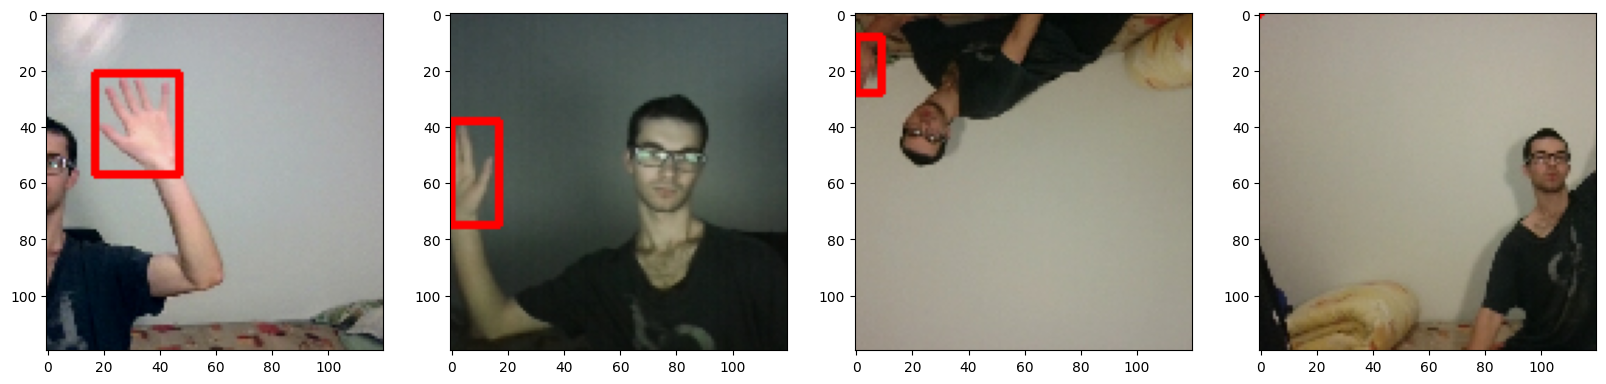

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

# Create the Deep Learning Model

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [45]:
vgg = VGG16(include_top=False)

In [46]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [48]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    tracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return tracker

In [49]:
tracker = build_model()

In [50]:
tracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_7[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_4 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [51]:
X, y = train.as_numpy_iterator().next()

2023-12-01 13:35:02.105887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 7482 of 32280
2023-12-01 13:35:12.106383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 13527 of 32280
2023-12-01 13:35:18.224034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [53]:
X.shape

(8, 120, 120, 3)

In [54]:
classes, coords = tracker.predict(X)

2023-12-01 13:37:36.718422: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-01 13:37:36.951112: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 13:37:38.327927: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


In [55]:
classes, coords

(array([[0.364385  ],
        [0.30914667],
        [0.2880539 ],
        [0.35609472],
        [0.34052065],
        [0.40542343],
        [0.35702848],
        [0.2106072 ]], dtype=float32),
 array([[0.7092956 , 0.39209738, 0.61178243, 0.58626264],
        [0.7265818 , 0.38466167, 0.6341676 , 0.5879009 ],
        [0.69506687, 0.4027935 , 0.61921704, 0.54816824],
        [0.7720931 , 0.37942415, 0.65176135, 0.53390825],
        [0.73600215, 0.37581813, 0.59303886, 0.5600037 ],
        [0.6900341 , 0.46293008, 0.6356612 , 0.56157404],
        [0.7036654 , 0.35639757, 0.6369593 , 0.55972564],
        [0.6719866 , 0.39170066, 0.66669554, 0.62382525]], dtype=float32))

# Define Loss Functions

In [56]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [57]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [58]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [59]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [60]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0943625>

In [61]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1285563>

In [62]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0943625>

In [63]:
class Tracker(Model):
    def __init__(self, tracker, **kwargs):
        super().__init__(**kwargs)
        self.model = tracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [64]:
model = Tracker(tracker)

In [65]:
model.compile(opt, classloss, regressloss)

In [66]:
logdir='logs'

In [67]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [68]:
start = time.time()
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])
end = time.time()
print(f'Training took {end - start} seconds')

Epoch 1/10


2023-12-01 13:38:13.737757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 12849 of 32280
2023-12-01 13:38:15.608271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-12-01 13:38:16.864013: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-01 13:38:16.969166: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-01 13:38:17.043634: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (

2017/2018 [============================>.] - ETA: 0s - total_loss: 0.7083 - class_loss: 0.2588 - regress_loss: 0.5789

2023-12-01 13:40:16.990179: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-01 13:40:17.062583: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2018/2018 [==============================] - 147s 64ms/step - total_loss: 0.7077 - class_loss: 0.2586 - regress_loss: 0.5784 - val_total_loss: 0.0248 - val_class_loss: 0.0018 - val_regress_loss: 0.0239
Epoch 2/10


2023-12-01 13:40:38.664327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 13396 of 32280


   3/2018 [..............................] - ETA: 2:01 - total_loss: 0.4578 - class_loss: 0.3542 - regress_loss: 0.2807

2023-12-01 13:40:40.124813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


2018/2018 [==============================] - 141s 64ms/step - total_loss: 0.2422 - class_loss: 0.0973 - regress_loss: 0.1936 - val_total_loss: 0.0640 - val_class_loss: 0.0356 - val_regress_loss: 0.0462
Epoch 3/10


2023-12-01 13:42:59.724346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 13934 of 32280


   3/2018 [..............................] - ETA: 2:04 - total_loss: 0.0965 - class_loss: 0.0200 - regress_loss: 0.0864

2023-12-01 13:43:01.329779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


2018/2018 [==============================] - 141s 64ms/step - total_loss: 0.1666 - class_loss: 0.0666 - regress_loss: 0.1333 - val_total_loss: 1.2180 - val_class_loss: 1.6446 - val_regress_loss: 0.3957
Epoch 4/10
2018/2018 [==============================] - 138s 64ms/step - total_loss: 0.1214 - class_loss: 0.0481 - regress_loss: 0.0973 - val_total_loss: 0.0296 - val_class_loss: 6.0088e-04 - val_regress_loss: 0.0293
Epoch 5/10


2023-12-01 13:47:39.428527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 15673 of 32280


   3/2018 [..............................] - ETA: 2:04 - total_loss: 0.3662 - class_loss: 0.0875 - regress_loss: 0.3225

2023-12-01 13:47:39.677320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


2018/2018 [==============================] - 139s 64ms/step - total_loss: 0.0935 - class_loss: 0.0366 - regress_loss: 0.0752 - val_total_loss: 0.2944 - val_class_loss: 0.1994 - val_regress_loss: 0.1947
Epoch 6/10
2018/2018 [==============================] - 132s 62ms/step - total_loss: 0.0747 - class_loss: 0.0286 - regress_loss: 0.0604 - val_total_loss: 0.6259 - val_class_loss: 0.9545 - val_regress_loss: 0.1486
Epoch 7/10


2023-12-01 13:52:11.249654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 15858 of 32280
2023-12-01 13:52:11.395193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


2018/2018 [==============================] - 139s 64ms/step - total_loss: 0.0620 - class_loss: 0.0237 - regress_loss: 0.0501 - val_total_loss: 0.0520 - val_class_loss: 0.0226 - val_regress_loss: 0.0407
Epoch 8/10


2023-12-01 13:54:30.174498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 15397 of 32280


   3/2018 [..............................] - ETA: 2:14 - total_loss: 0.0678 - class_loss: 0.0157 - regress_loss: 0.0600

2023-12-01 13:54:30.808659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


2018/2018 [==============================] - 140s 64ms/step - total_loss: 0.0474 - class_loss: 0.0181 - regress_loss: 0.0383 - val_total_loss: 0.0132 - val_class_loss: 0.0022 - val_regress_loss: 0.0121
Epoch 9/10


2023-12-01 13:56:50.592040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 15595 of 32280


   3/2018 [..............................] - ETA: 1:59 - total_loss: 0.0111 - class_loss: 0.0036 - regress_loss: 0.0093

2023-12-01 13:56:50.952832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


2018/2018 [==============================] - 139s 64ms/step - total_loss: 0.0414 - class_loss: 0.0173 - regress_loss: 0.0327 - val_total_loss: 0.0144 - val_class_loss: 0.0107 - val_regress_loss: 0.0091
Epoch 10/10
2018/2018 [==============================] - 139s 64ms/step - total_loss: 0.0331 - class_loss: 0.0126 - regress_loss: 0.0268 - val_total_loss: 0.0608 - val_class_loss: 0.0501 - val_regress_loss: 0.0357


In [69]:
hist.history

{'total_loss': [0.05040790140628815,
  0.0131742674857378,
  0.012005701661109924,
  0.00986467394977808,
  0.009600498713552952,
  0.0035129128955304623,
  0.0027984471525996923,
  0.006099130492657423,
  0.004811188206076622,
  0.0013980289222672582],
 'class_loss': [0.026398567482829094,
  0.0027122418396174908,
  0.00726801622658968,
  0.00021349867165554315,
  0.0007229059701785445,
  0.004430795554071665,
  0.00014923005073796958,
  0.0011334767332300544,
  0.002838090993463993,
  0.00020291544205974787],
 'regress_loss': [0.037208616733551025,
  0.011818146333098412,
  0.008371694013476372,
  0.00975792482495308,
  0.009239045903086662,
  0.0012975151184946299,
  0.0027238321490585804,
  0.005532392300665379,
  0.0033921427093446255,
  0.001296571223065257],
 'val_total_loss': [0.02481597475707531,
  0.06398370116949081,
  1.2180415391921997,
  0.02957814745604992,
  0.2943839728832245,
  0.6258869171142578,
  0.051995791494846344,
  0.013216736726462841,
  0.014409670606255531,

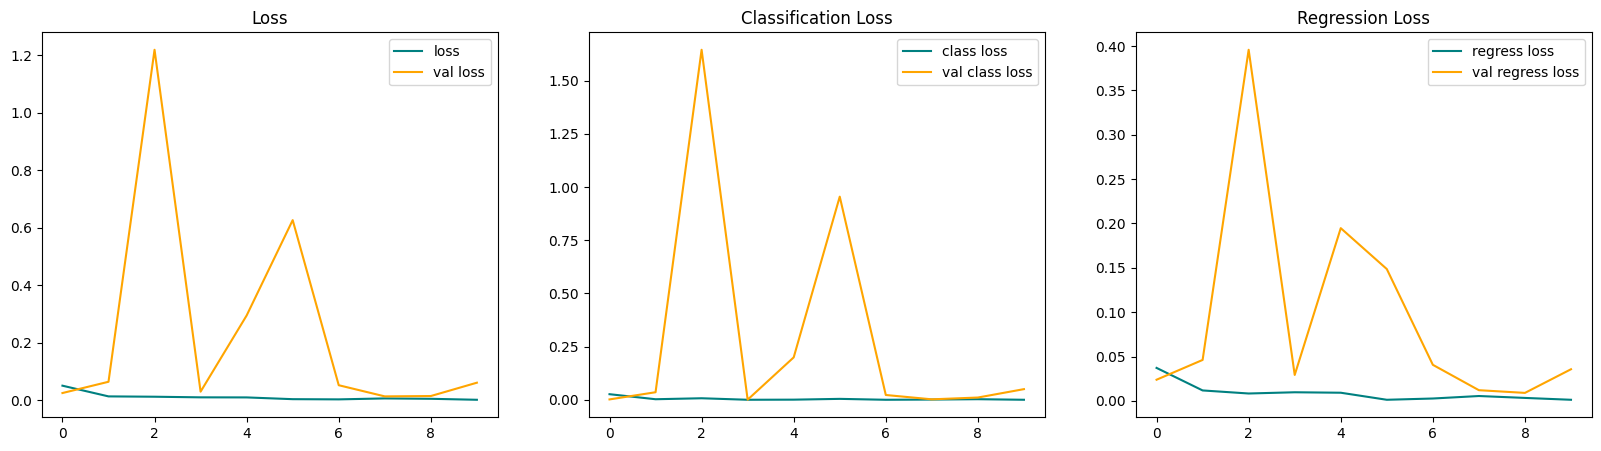

In [70]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Predictions

In [71]:
test_data = test.as_numpy_iterator()

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


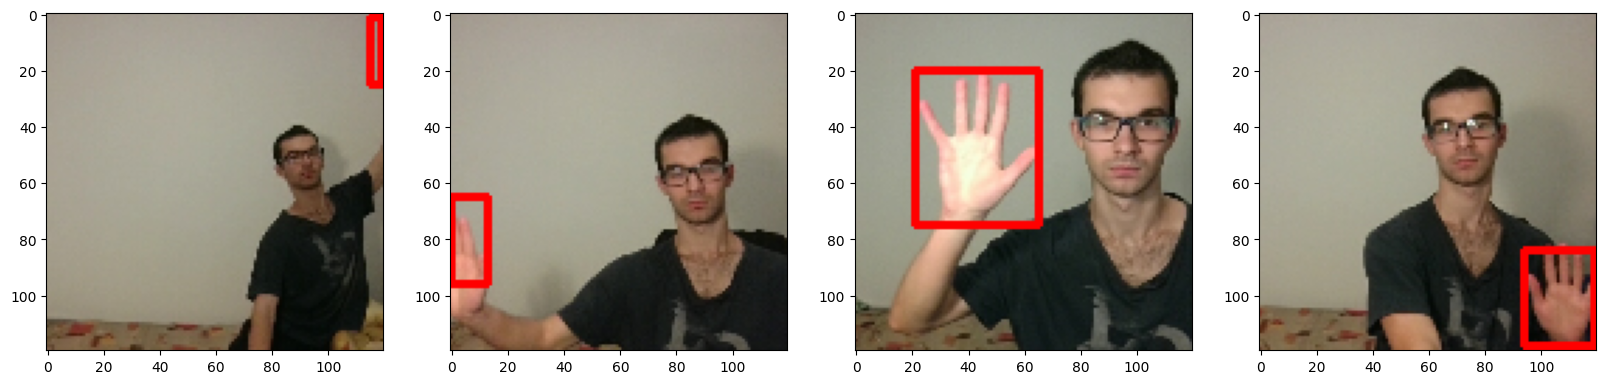

In [75]:
test_sample = test_data.next()
yhat = tracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

In [76]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(1420.5709, shape=(), dtype=float32)


In [77]:
from tensorflow.keras.models import load_model
tracker.save('tracker.h5')

/mnt/e/UBB_IE_2020-2023/S6.BE/v3/handrecognitionvenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# if the camera fails to run (cv2.error: OpenCV(4.8.1) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented.  -> https://stackoverflow.com/questions/67120450/error-2unspecified-error-the-function-is-not-implemented-rebuild-the-libra)
!pip uninstall opencv-python 
!pip install opencv-python

In [78]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model

tracker = load_model('tracker.h5')
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = tracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [80, 0])),
                      (255, 0, 0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'hand', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('HandTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 14ms/step
